In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
!{sys.executable} -m pip install pandas-profiling
!{sys.executable} -m pip install pandasql 
from pandasql import sqldf
import pandas_profiling

###############################################################################################
# Process Clinical data
###############################################################################################

patient_data = pd.read_csv('patient_data.csv')
patient = pd.read_csv('patient_data.csv')

patient = patient.set_index('track_name').T
patient = patient[1:]
patient = patient.reset_index()
patient = patient.rename(columns = {'index':'ID'})

patient['ID'] = patient['ID'].str.upper()
patient['Diagnosis Age'] = pd.to_numeric(patient['Diagnosis Age'])
patient['Overall Survival (Months)'] = pd.to_numeric(patient['Overall Survival (Months)'])
patient['Mutation Count'] = pd.to_numeric(patient['Mutation Count'])
patient['Sex'] = patient['Sex'].str.lower()
patient = patient[patient['# Samples per Patient']!='2'].reset_index(drop=True)

def label(x):
    if 'T1' in x:
        return 'T1'
    if 'T2' in x:
        return 'T2'
    if 'T3' in x:
        return 'T3'
    return 'T4'
patient['Stage'] = patient['American Joint Committee on Cancer Tumor Stage Code'].apply(lambda x: label(x))

patient = patient.drop(['Profiled in Mutations','Profiled in Putative copy-number alterations from GISTIC','Patient\'s Vital Status','# Samples per Patient','Cancer Type','Informed consent verified','Neoplasm Histologic Type Name'],axis=1)

###############################################################################################
# Process Tumor mRNA gene expression data
###############################################################################################

mrna_data = pd.read_csv('mrna_data.txt',sep='\t')
mrna = pd.read_csv('mrna_data.txt',sep='\t')

mrna.dropna(thresh=1,axis=1,inplace=True)
mrna = mrna.drop(['STUDY_ID'],axis=1)

def id_process(x):
    new = x[:len(x)-3]
    new = new.replace("_","")
    return new.upper()
mrna['SAMPLE_ID'] = mrna['SAMPLE_ID'].apply(lambda x: id_process(x))

###############################################################################################
# Process Tumor Mutation Sequencing data
###############################################################################################

seq_data = pd.read_csv('seq_data.txt',sep='\t')
seq = pd.read_csv('seq_data.txt',sep='\t')

seq.dropna(how='all',axis=1,inplace=True)
seq = seq.fillna(0)
seq = seq.drop(['STUDY_ID'],axis=1)
seq['SAMPLE_ID'] = seq['SAMPLE_ID'].apply(lambda x: id_process(x))

###############################################################################################
# Process combined dataframe
###############################################################################################

def pysqldf(q):
    return sqldf(q, globals())

q = '''
SELECT *
FROM patient
JOIN mrna
ON patient.ID = mrna.SAMPLE_ID
JOIN seq
ON patient.ID = seq.SAMPLE_ID
'''
df = pysqldf(q)

df = df.drop(['SAMPLE_ID'],axis=1)



UsageError: Line magic function `%%hide` not found.


In [16]:
df.to_csv ('df.csv')

In [17]:
col_with_null = df.loc[:,df.isnull().sum(axis=0)>0]

In [18]:
nulls = col_with_null[col_with_null.isnull().any(axis=1)]
ind = nulls.index

In [69]:
df.iloc[ind,4:6]

,Neoplasm Histologic Grade,Race Category
30,G2,WHITE
64,None,BLACK OR AFRICAN AMERICAN
88,G2,WHITE
158,G3,WHITE
179,G2,WHITE
196,None,BLACK OR AFRICAN AMERICAN
275,None,WHITE
276,G2,WHITE
349,G3,WHITE
483,G2,WHITE


In [37]:
fitting = df

In [38]:
fitting = fitting.iloc[:,:90]

In [39]:
fitting = fitting.drop(['ID','American Joint Committee on Cancer Tumor Stage Code','Overall Survival Status','Sex','Stage'],axis=1)

In [40]:
fitting 

,Diagnosis Age,Overall Survival (Months),Neoplasm Histologic Grade,Race Category,Mutation Count,CASR,BEX1,MYH8,SPON1,FABP4,...,NMRK2,GAL3ST3,MYMK,PLPPR5,GALNT9,UBE2QL1,KCNK3,PCDHB1,CXADRP3,LRRTM3
0,49,20.27,G2,WHITE,70,-0.2189,-0.3900,-0.3361,-0.5138,-0.3317,...,-0.0830,-0.1707,-0.2581,0.2143,-0.7927,-0.3291,-0.2567,-0.1539,-0.1217,0.0041
1,51,43.17,G2,BLACK OR AFRICAN AMERICAN,934,-0.3084,1.4953,-0.3371,-0.6901,-0.2625,...,-0.0274,-0.2045,-0.2581,-0.7088,-0.7921,1.3842,-0.9107,-0.3519,-0.4425,-0.4822
2,50,10.48,G2,ASIAN,1392,-0.2440,-0.3324,0.4572,9.8551,-0.4222,...,-0.0830,-0.0711,-0.2581,2.3981,-0.1062,-0.4213,-0.9130,0.6727,0.8858,-0.4822
3,55,94.38,G2,WHITE,52,-0.3065,-0.3557,-0.3371,-0.6237,-0.3941,...,-0.0834,-0.2214,-0.2581,0.3389,-0.7828,-0.3776,-0.3862,-0.3519,-0.0984,-0.4822
4,64,64.22,G2,WHITE,85,-0.3208,-0.3619,-0.3335,-0.6163,-0.4168,...,-0.0831,-0.2204,-0.2581,1.6625,-0.5232,-0.2374,-0.6744,-0.3519,0.7024,-0.4822
5,63,119.55,G3,WHITE,42,15.0343,-0.3478,2.8270,2.3959,-0.2378,...,-0.0834,-0.0367,-0.2581,2.0796,2.8367,-0.0034,2.6966,-0.3519,-0.4425,-0.4822
6,59,23.46,G2,WHITE,46,2.3700,1.1286,2.6795,-0.6950,-0.3297,...,-0.0833,-0.1788,2.1204,-0.7067,1.8769,0.0741,0.5387,-0.3519,-0.1193,-0.4822
7,51,85.71,G2,WHITE,41,5.7473,-0.3720,-0.2978,3.7813,-0.0900,...,-0.0834,-0.2157,0.4244,-0.2330,-0.1921,-0.1149,-0.6306,5.4844,-0.1644,0.9936
8,66,112.71,G3,WHITE,55,2.7828,-0.1937,0.1911,1.1727,-0.3629,...,-0.0805,0.4493,1.7371,-0.0836,0.0447,-0.2206,-0.7109,-0.0173,-0.4425,1.1613
9,58,83.15,G2,WHITE,350,14.0383,-0.2590,-0.3371,-0.6945,0.3441,...,-0.0766,0.0422,0.1464,-0.7109,-0.7739,-0.3746,-0.9265,1.8864,-0.1127,33.0062


In [42]:
race_fit = fitting.drop(['Neoplasm Histologic Grade'],axis=1)

In [43]:
race_fit

,Diagnosis Age,Overall Survival (Months),Race Category,Mutation Count,CASR,BEX1,MYH8,SPON1,FABP4,SLITRK5,...,NMRK2,GAL3ST3,MYMK,PLPPR5,GALNT9,UBE2QL1,KCNK3,PCDHB1,CXADRP3,LRRTM3
0,49,20.27,WHITE,70,-0.2189,-0.3900,-0.3361,-0.5138,-0.3317,-0.0256,...,-0.0830,-0.1707,-0.2581,0.2143,-0.7927,-0.3291,-0.2567,-0.1539,-0.1217,0.0041
1,51,43.17,BLACK OR AFRICAN AMERICAN,934,-0.3084,1.4953,-0.3371,-0.6901,-0.2625,-0.5939,...,-0.0274,-0.2045,-0.2581,-0.7088,-0.7921,1.3842,-0.9107,-0.3519,-0.4425,-0.4822
2,50,10.48,ASIAN,1392,-0.2440,-0.3324,0.4572,9.8551,-0.4222,-0.0040,...,-0.0830,-0.0711,-0.2581,2.3981,-0.1062,-0.4213,-0.9130,0.6727,0.8858,-0.4822
3,55,94.38,WHITE,52,-0.3065,-0.3557,-0.3371,-0.6237,-0.3941,-0.0430,...,-0.0834,-0.2214,-0.2581,0.3389,-0.7828,-0.3776,-0.3862,-0.3519,-0.0984,-0.4822
4,64,64.22,WHITE,85,-0.3208,-0.3619,-0.3335,-0.6163,-0.4168,1.6013,...,-0.0831,-0.2204,-0.2581,1.6625,-0.5232,-0.2374,-0.6744,-0.3519,0.7024,-0.4822
5,63,119.55,WHITE,42,15.0343,-0.3478,2.8270,2.3959,-0.2378,0.4683,...,-0.0834,-0.0367,-0.2581,2.0796,2.8367,-0.0034,2.6966,-0.3519,-0.4425,-0.4822
6,59,23.46,WHITE,46,2.3700,1.1286,2.6795,-0.6950,-0.3297,-0.5588,...,-0.0833,-0.1788,2.1204,-0.7067,1.8769,0.0741,0.5387,-0.3519,-0.1193,-0.4822
7,51,85.71,WHITE,41,5.7473,-0.3720,-0.2978,3.7813,-0.0900,0.3211,...,-0.0834,-0.2157,0.4244,-0.2330,-0.1921,-0.1149,-0.6306,5.4844,-0.1644,0.9936
8,66,112.71,WHITE,55,2.7828,-0.1937,0.1911,1.1727,-0.3629,0.5175,...,-0.0805,0.4493,1.7371,-0.0836,0.0447,-0.2206,-0.7109,-0.0173,-0.4425,1.1613
9,58,83.15,WHITE,350,14.0383,-0.2590,-0.3371,-0.6945,0.3441,-0.3078,...,-0.0766,0.0422,0.1464,-0.7109,-0.7739,-0.3746,-0.9265,1.8864,-0.1127,33.0062


In [45]:
null_index = race_fit.isnull().any(axis=1)

In [47]:
row_with_null = race_fit[null_index]

In [48]:
row_no_null = race_fit[-null_index]

In [52]:
from sklearn.neighbors import KNeighborsClassifier

In [53]:
clf = KNeighborsClassifier(3, weights='distance')

In [55]:
x = row_no_null.drop(['Race Category'],axis=1)
y = row_no_null['Race Category']

In [56]:
clf.fit(x,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')

In [58]:
x_test = row_with_null.drop(['Race Category'],axis=1)

In [59]:
imputes = clf.predict(x_test)

In [60]:
imputes

array(['WHITE', 'WHITE', 'WHITE', 'WHITE', 'WHITE', 'WHITE', 'WHITE'],
      dtype=object)

In [68]:
df.loc[null_index,'Race Category'] = imputes 

In [20]:
mode_imp = df.copy(deep=True)
mode_imp['Race Category'].fillna(mode_imp['Race Category'].mode(), inplace = True)

/Users/yuchen/anaconda3/envs/ds_pack/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [21]:
mode_imp['Race Category'].isnull().sum()

7

In [22]:
mode_imp.iloc[ind,4:6]

,Neoplasm Histologic Grade,Race Category
30,G2,None
64,None,BLACK OR AFRICAN AMERICAN
88,G2,None
158,G3,None
179,G2,None
196,None,BLACK OR AFRICAN AMERICAN
275,None,WHITE
276,G2,None
349,G3,None
483,G2,None


NameError: name 'X' is not defined

In [ ]:
mode_imp['Race Category'].fillna(0,inplace=True)

In [ ]:
mode_imp['Race Category'].isnull().sum()

In [ ]:
mode_imp['Race Category'] = df['Race Category'].fillna(df['Race Category'].mode())

In [ ]:
mode_imp = df.copy(deep=True)
mode_imp['Race Category'] = mode_imp['Race Category'].fillna(mode_imp['Race Category'].mode()[0])

In [ ]:
mo = mode_imp['Race Category'].mode()[0]

In [ ]:
s = mode_imp['Race Category'].fillna(mo)

In [ ]:
mode_imp['Race Category'] = mode_imp['Race Category'].fillna(mo)

In [ ]:
s.isnull().sum()

In [ ]:
df['Race Category'].isnull().sum()

In [ ]:
mode_imp['Race Category'].isnull().sum()

In [ ]:
mode_imp.fillna(1, inplace=True)

In [ ]:
col_with_null = mode_imp.loc[:,mode_imp.isnull().sum(axis=0)>0]
col_with_null[col_with_null.isnull().any(axis=1)]

In [ ]:
a

In [ ]:
mo = df['Race Category'].mode()
a = df['Race Category'].fillna(mo[0])

In [ ]:
type(mo)

In [ ]:
a.isnull().sum()

In [ ]:
median = df["Overall Survival (Months)"].median()

In [ ]:
type(median)

In [ ]:
mo[0]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_imp = df.copy(deep=True)

In [ ]:
knn_imp = knn_imp.iloc[:,:90]

In [ ]:
df.columns 

In [ ]:
X = knn_imp
X['Race Category'] = mode_imp['Race Category']

In [ ]:
row_with_nan = X[X.isnull().any(axis=1)]
idx_with_nan = X.isnull().any(axis=1)

In [ ]:
row_with_nan

In [ ]:
row_no_nan = X[-X.isnull().any(axis=1)]
row_no_nan

In [ ]:
clf = KNeighborsClassifier(3, weights='distance')

In [ ]:
fitting = row_no_nan

In [ ]:
fitting.iloc[:,:20]

In [ ]:
fitting = fitting.drop(['ID','American Joint Committee on Cancer Tumor Stage Code','Race Category','Overall Survival Status','Sex','Stage'],axis=1)

In [ ]:
x = fitting.drop(['Neoplasm Histologic Grade'],axis=1)

In [ ]:
y = fitting['Neoplasm Histologic Grade']

In [ ]:
clf.fit(x,y)

In [ ]:
testing = row_with_nan

In [ ]:
testing = testing.drop(['ID','American Joint Committee on Cancer Tumor Stage Code','Race Category','Overall Survival Status','Sex','Stage'],axis=1)

In [ ]:
testing

In [ ]:
x_test = testing.drop(['Neoplasm Histologic Grade'],axis=1)

In [ ]:
x_test

In [ ]:
imputes = clf.predict(x_test)

In [ ]:
imputes.reshape(3)

In [ ]:
type(knn_imp.loc[idx_with_nan,'Neoplasm Histologic Grade'] )

In [ ]:
type(imputes)

In [ ]:
knn_imp.loc[idx_with_nan,'Neoplasm Histologic Grade'] = imputes

In [ ]:
knn_imp.loc[idx_with_nan,'Neoplasm Histologic Grade']

In [ ]:
knn_imp[knn_imp.isnull().any(axis=1)]

In [24]:
knn_imp

NameError: name 'knn_imp' is not defined

In [25]:
mode_imp

,ID,American Joint Committee on Cancer Tumor Stage Code,Diagnosis Age,Overall Survival (Months),Neoplasm Histologic Grade,Race Category,Overall Survival Status,Sex,Mutation Count,Stage,...,STARD6,NTRK2,FOXP2,KCNJ1,MS4A3,OR51B4,GALNT9,KCNK3,PCDHB1,LRRTM3
0,CG-A3-3387,T1a,49,20.27,G2,WHITE,LIVING,male,70,T1,...,0,0,0,0,0,0,0,0,0,0
1,CG-A3-3374,T1b,51,43.17,G2,BLACK OR AFRICAN AMERICAN,LIVING,female,934,T1,...,0,0,0,0,0,0,0,0,0,0
2,CG-A3-3363,T2,50,10.48,G2,ASIAN,LIVING,male,1392,T2,...,0,0,0,0,0,0,0,0,0,0
3,CG-CZ-5460,T3b,55,94.38,G2,WHITE,LIVING,male,52,T3,...,0,0,0,0,0,0,0,0,0,0
4,CG-BP-4176,T1b,64,64.22,G2,WHITE,LIVING,male,85,T1,...,0,0,0,0,0,0,0,0,0,0
5,CG-CJ-6032,T2,63,119.55,G3,WHITE,LIVING,female,42,T2,...,0,0,0,0,0,0,0,0,0,0
6,CG-BP-5192,T1a,59,23.46,G2,WHITE,LIVING,male,46,T1,...,0,0,0,0,0,0,0,0,0,0
7,CG-CW-5585,T3b,51,85.71,G2,WHITE,LIVING,male,41,T3,...,0,0,0,0,0,0,0,0,0,0
8,CG-B0-5691,T1a,66,112.71,G3,WHITE,LIVING,female,55,T1,...,0,0,0,0,0,0,0,0,0,0
9,CG-AK-3453,T2,58,83.15,G2,WHITE,LIVING,female,350,T2,...,0,0,0,0,0,0,0,0,0,0


In [70]:
fitting.shape

(532, 85)

In [71]:
df.shape

(532, 134)

In [75]:
num_features = df.iloc[:,:90]
num_features = num_features.drop(['ID','Neoplasm Histologic Grade','American Joint Committee on Cancer Tumor Stage Code','Race Category','Overall Survival Status','Sex','Stage'],axis=1)

In [76]:
num_features.shape

(532, 83)

In [78]:
corr = num_features.corr()

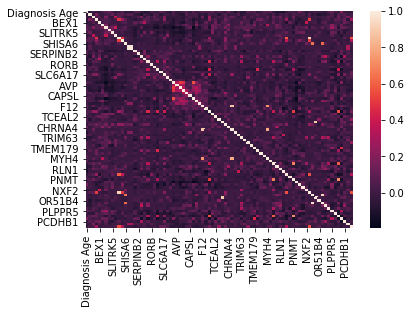

In [79]:
sns.heatmap(corr)

In [98]:
df.isnull().sum().sum(axis=0)

0

In [97]:
grade_fit = fitting.drop(['Race Category'],axis=1)
null_index = grade_fit.isnull().any(axis=1)
row_with_null = grade_fit[null_index]
row_no_null = grade_fit[-null_index]

clf = KNeighborsClassifier(3, weights='distance')
x = row_no_null.drop(['Neoplasm Histologic Grade'],axis=1)
y = row_no_null['Neoplasm Histologic Grade']
clf.fit(x,y)
x_test = row_with_null.drop(['Neoplasm Histologic Grade'],axis=1)
imputes = clf.predict(x_test)

df.loc[null_index,'Neoplasm Histologic Grade'] = imputes 

In [103]:
df

,ID,American Joint Committee on Cancer Tumor Stage Code,Diagnosis Age,Overall Survival (Months),Neoplasm Histologic Grade,Race Category,Overall Survival Status,Sex,Mutation Count,Stage,...,STARD6,NTRK2,FOXP2,KCNJ1,MS4A3,OR51B4,GALNT9,KCNK3,PCDHB1,LRRTM3
0,CG-A3-3387,T1a,49,20.27,G2,WHITE,LIVING,male,70,T1,...,0,0,0,0,0,0,0,0,0,0
1,CG-A3-3374,T1b,51,43.17,G2,BLACK OR AFRICAN AMERICAN,LIVING,female,934,T1,...,0,0,0,0,0,0,0,0,0,0
2,CG-A3-3363,T2,50,10.48,G2,ASIAN,LIVING,male,1392,T2,...,0,0,0,0,0,0,0,0,0,0
3,CG-CZ-5460,T3b,55,94.38,G2,WHITE,LIVING,male,52,T3,...,0,0,0,0,0,0,0,0,0,0
4,CG-BP-4176,T1b,64,64.22,G2,WHITE,LIVING,male,85,T1,...,0,0,0,0,0,0,0,0,0,0
5,CG-CJ-6032,T2,63,119.55,G3,WHITE,LIVING,female,42,T2,...,0,0,0,0,0,0,0,0,0,0
6,CG-BP-5192,T1a,59,23.46,G2,WHITE,LIVING,male,46,T1,...,0,0,0,0,0,0,0,0,0,0
7,CG-CW-5585,T3b,51,85.71,G2,WHITE,LIVING,male,41,T3,...,0,0,0,0,0,0,0,0,0,0
8,CG-B0-5691,T1a,66,112.71,G3,WHITE,LIVING,female,55,T1,...,0,0,0,0,0,0,0,0,0,0
9,CG-AK-3453,T2,58,83.15,G2,WHITE,LIVING,female,350,T2,...,0,0,0,0,0,0,0,0,0,0


In [101]:
df_temp = df

In [105]:
df_temp = df.drop(['ID','American Joint Committee on Cancer Tumor Stage Code'],axis=1)

In [106]:
df_temp

,Diagnosis Age,Overall Survival (Months),Neoplasm Histologic Grade,Race Category,Overall Survival Status,Sex,Mutation Count,Stage,CASR,BEX1,...,STARD6,NTRK2,FOXP2,KCNJ1,MS4A3,OR51B4,GALNT9,KCNK3,PCDHB1,LRRTM3
0,49,20.27,G2,WHITE,LIVING,male,70,T1,-0.2189,-0.3900,...,0,0,0,0,0,0,0,0,0,0
1,51,43.17,G2,BLACK OR AFRICAN AMERICAN,LIVING,female,934,T1,-0.3084,1.4953,...,0,0,0,0,0,0,0,0,0,0
2,50,10.48,G2,ASIAN,LIVING,male,1392,T2,-0.2440,-0.3324,...,0,0,0,0,0,0,0,0,0,0
3,55,94.38,G2,WHITE,LIVING,male,52,T3,-0.3065,-0.3557,...,0,0,0,0,0,0,0,0,0,0
4,64,64.22,G2,WHITE,LIVING,male,85,T1,-0.3208,-0.3619,...,0,0,0,0,0,0,0,0,0,0
5,63,119.55,G3,WHITE,LIVING,female,42,T2,15.0343,-0.3478,...,0,0,0,0,0,0,0,0,0,0
6,59,23.46,G2,WHITE,LIVING,male,46,T1,2.3700,1.1286,...,0,0,0,0,0,0,0,0,0,0
7,51,85.71,G2,WHITE,LIVING,male,41,T3,5.7473,-0.3720,...,0,0,0,0,0,0,0,0,0,0
8,66,112.71,G3,WHITE,LIVING,female,55,T1,2.7828,-0.1937,...,0,0,0,0,0,0,0,0,0,0
9,58,83.15,G2,WHITE,LIVING,female,350,T2,14.0383,-0.2590,...,0,0,0,0,0,0,0,0,0,0


In [165]:
x = df_temp.drop(['Overall Survival (Months)','Overall Survival Status'],axis=1)

In [166]:
x = pd.get_dummies(x, columns=['Sex','Race Category','Neoplasm Histologic Grade','Stage'])

In [198]:
x_seq = x.iloc[:,82:126]


In [202]:
x_seq.shape

(532, 149)

In [201]:
x_seq = pd.get_dummies(x_seq, columns = x_seq.columns)


In [204]:
x.iloc[:,82:126]

,CASR,MYH8,SPON1,SLITRK5,LYPD4,SPAG11A,SORCS3,BNC1,DIPK1C,RORB,...,STARD6,NTRK2,FOXP2,KCNJ1,MS4A3,OR51B4,GALNT9,KCNK3,PCDHB1,LRRTM3
0,F788Y,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,L37Afs*11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,V104I,0,X543_splice,V8Sfs*13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,T712I,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,G325R,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [203]:
x_seq

,CASR_0,CASR_F788Y,CASR_G325R,CASR_L37Afs*11,CASR_T712I,CASR_V104I,MYH8_0,MYH8_A1675V,MYH8_D162Y,MYH8_E1476G D1036G,...,KCNK3_0,KCNK3_G117D,PCDHB1_0,PCDHB1_G428R,PCDHB1_P467L,PCDHB1_R79S,LRRTM3_0,LRRTM3_L138F,LRRTM3_N233K,LRRTM3_N504K
0,0,1,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
1,0,0,0,1,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
2,0,0,0,0,0,1,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
3,0,0,0,0,1,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
4,0,0,1,0,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
5,1,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
6,1,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
7,1,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
8,1,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0
9,1,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,1,0,0,0


In [182]:
seq_names = x.iloc[:,82:126].columns

In [183]:
seq_names = seq_names.to_series()
seq_names = seq_names.apply(lambda x: x.lower())

In [190]:
x.iloc[:,82:126].columns = seq_names

In [191]:
x.iloc[:,82:126].columns

Index(['CASR', 'MYH8', 'SPON1', 'SLITRK5', 'LYPD4', 'SPAG11A', 'SORCS3',
       'BNC1', 'DIPK1C', 'RORB', 'FGF7', 'ROS1', 'SLC6A17', 'SCG2', 'KCND2',
       'CAPSL', 'F12', 'TCEAL2', 'SLITRK6', 'DEFA4', 'SORCS1', 'CHRNA4',
       'ABCG8', 'SLC17A8', 'CD5L', 'TRIM63', 'DPEP1', 'KCTD8', 'C16ORF78',
       'PRSS12', 'MYH4', 'USH1G', 'RLN1', 'EPHA7', 'STARD6', 'NTRK2', 'FOXP2',
       'KCNJ1', 'MS4A3', 'OR51B4', 'GALNT9', 'KCNK3', 'PCDHB1', 'LRRTM3'],
      dtype='object')

In [192]:
sq_name = ['CASR', 'MYH8', 'SPON1', 'SLITRK5', 'LYPD4', 'SPAG11A', 'SORCS3',
       'BNC1', 'DIPK1C', 'RORB', 'FGF7', 'ROS1', 'SLC6A17', 'SCG2', 'KCND2',
       'CAPSL', 'F12', 'TCEAL2', 'SLITRK6', 'DEFA4', 'SORCS1', 'CHRNA4',
       'ABCG8', 'SLC17A8', 'CD5L', 'TRIM63', 'DPEP1', 'KCTD8', 'C16ORF78',
       'PRSS12', 'MYH4', 'USH1G', 'RLN1', 'EPHA7', 'STARD6', 'NTRK2', 'FOXP2',
       'KCNJ1', 'MS4A3', 'OR51B4', 'GALNT9', 'KCNK3', 'PCDHB1', 'LRRTM3']

In [194]:
sq_name[0] = 1

In [195]:
sq_name

[1,
 'MYH8',
 'SPON1',
 'SLITRK5',
 'LYPD4',
 'SPAG11A',
 'SORCS3',
 'BNC1',
 'DIPK1C',
 'RORB',
 'FGF7',
 'ROS1',
 'SLC6A17',
 'SCG2',
 'KCND2',
 'CAPSL',
 'F12',
 'TCEAL2',
 'SLITRK6',
 'DEFA4',
 'SORCS1',
 'CHRNA4',
 'ABCG8',
 'SLC17A8',
 'CD5L',
 'TRIM63',
 'DPEP1',
 'KCTD8',
 'C16ORF78',
 'PRSS12',
 'MYH4',
 'USH1G',
 'RLN1',
 'EPHA7',
 'STARD6',
 'NTRK2',
 'FOXP2',
 'KCNJ1',
 'MS4A3',
 'OR51B4',
 'GALNT9',
 'KCNK3',
 'PCDHB1',
 'LRRTM3']

In [186]:
seq_names = seq_names.reset_index(drop=True)

In [187]:
seq_names

0         casr
1         myh8
2        spon1
3      slitrk5
4        lypd4
5      spag11a
6       sorcs3
7         bnc1
8       dipk1c
9         rorb
10        fgf7
11        ros1
12     slc6a17
13        scg2
14       kcnd2
15       capsl
16         f12
17      tceal2
18     slitrk6
19       defa4
20      sorcs1
21      chrna4
22       abcg8
23     slc17a8
24        cd5l
25      trim63
26       dpep1
27       kctd8
28    c16orf78
29      prss12
30        myh4
31       ush1g
32        rln1
33       epha7
34      stard6
35       ntrk2
36       foxp2
37       kcnj1
38       ms4a3
39      or51b4
40      galnt9
41       kcnk3
42      pcdhb1
43      lrrtm3
dtype: object

In [196]:
x.iloc[:,82:126].columns = sq_name

In [197]:
x.iloc[:,82:126].columns

Index(['CASR', 'MYH8', 'SPON1', 'SLITRK5', 'LYPD4', 'SPAG11A', 'SORCS3',
       'BNC1', 'DIPK1C', 'RORB', 'FGF7', 'ROS1', 'SLC6A17', 'SCG2', 'KCND2',
       'CAPSL', 'F12', 'TCEAL2', 'SLITRK6', 'DEFA4', 'SORCS1', 'CHRNA4',
       'ABCG8', 'SLC17A8', 'CD5L', 'TRIM63', 'DPEP1', 'KCTD8', 'C16ORF78',
       'PRSS12', 'MYH4', 'USH1G', 'RLN1', 'EPHA7', 'STARD6', 'NTRK2', 'FOXP2',
       'KCNJ1', 'MS4A3', 'OR51B4', 'GALNT9', 'KCNK3', 'PCDHB1', 'LRRTM3'],
      dtype='object')

In [173]:
type(seq_names)

pandas.core.series.Series

In [152]:
x = pd.get_dummies(x, columns= seq_names)

In [153]:
x.shape

(532, 15609)

In [154]:
x

,Diagnosis Age,Mutation Count,BEX1,FABP4,CBLN2,DGKK,RGS7,SHISA6,SERPINB2,PCP4,...,LRRTM3_5.6189,LRRTM3_6.0367,LRRTM3_6.6343,LRRTM3_9.9891,LRRTM3_33.0062,LRRTM3_40.4833,LRRTM3_0,LRRTM3_L138F,LRRTM3_N233K,LRRTM3_N504K
0,49,70,-0.3900,-0.3317,-0.1675,-0.3360,0.9558,-0.3447,-0.1797,-0.1404,...,0,0,0,0,0,0,1,0,0,0
1,51,934,1.4953,-0.2625,-0.1345,-0.6173,-0.0498,-0.4834,-0.0852,1.3329,...,0,0,0,0,0,0,1,0,0,0
2,50,1392,-0.3324,-0.4222,16.2764,-0.6173,-0.2995,0.2904,-0.2532,0.9455,...,0,0,0,0,0,0,1,0,0,0
3,55,52,-0.3557,-0.3941,-0.3020,-0.6173,0.6674,-0.5220,-0.2532,-0.0651,...,0,0,0,0,0,0,1,0,0,0
4,64,85,-0.3619,-0.4168,-0.2730,-0.6173,-0.3010,-0.5220,0.9274,-0.1301,...,0,0,0,0,0,0,1,0,0,0
5,63,42,-0.3478,-0.2378,0.4648,-0.6173,-0.2319,-0.3014,-0.2532,-0.1415,...,0,0,0,0,0,0,1,0,0,0
6,59,46,1.1286,-0.3297,-0.2651,-0.0507,-0.3062,-0.5220,-0.2532,-0.1423,...,0,0,0,0,0,0,1,0,0,0
7,51,41,-0.3720,-0.0900,1.2776,0.6021,-0.3062,0.0708,-0.2532,-0.1415,...,0,0,0,0,0,0,1,0,0,0
8,66,55,-0.1937,-0.3629,0.4211,-0.6173,-0.2582,0.4192,-0.1290,0.0441,...,0,0,0,0,0,0,1,0,0,0
9,58,350,-0.2590,0.3441,0.1378,65.0104,11.5551,1.1695,-0.2532,-0.1404,...,0,0,0,0,1,0,1,0,0,0


In [125]:
y = df_temp[['Overall Survival (Months)','Overall Survival Status']]

In [128]:
y

,Overall Survival (Months),Overall Survival Status
0,20.27,1
1,43.17,1
2,10.48,1
3,94.38,1
4,64.22,1
5,119.55,1
6,23.46,1
7,85.71,1
8,112.71,1
9,83.15,1


In [127]:
y.loc[:,['Overall Survival Status']] = np.where(y['Overall Survival Status'] == 'LIVING',1,0)

In [132]:
survival_rate = y['Overall Survival Status'].sum()/y['Overall Survival Status'].shape[0]

In [133]:
survival_rate

0.6710526315789473

KeyError: "None of [Index(['Sex'], dtype='object')] are in the [columns]"

In [135]:
x

,Diagnosis Age,Neoplasm Histologic Grade,Race Category,Mutation Count,Stage,CASR,BEX1,MYH8,SPON1,FABP4,...,FOXP2,KCNJ1,MS4A3,OR51B4,GALNT9,KCNK3,PCDHB1,LRRTM3,Sex_female,Sex_male
0,49,G2,WHITE,70,T1,-0.2189,-0.3900,-0.3361,-0.5138,-0.3317,...,0,0,0,0,0,0,0,0,0,1
1,51,G2,BLACK OR AFRICAN AMERICAN,934,T1,-0.3084,1.4953,-0.3371,-0.6901,-0.2625,...,0,0,0,0,0,0,0,0,1,0
2,50,G2,ASIAN,1392,T2,-0.2440,-0.3324,0.4572,9.8551,-0.4222,...,0,0,0,0,0,0,0,0,0,1
3,55,G2,WHITE,52,T3,-0.3065,-0.3557,-0.3371,-0.6237,-0.3941,...,0,0,0,0,0,0,0,0,0,1
4,64,G2,WHITE,85,T1,-0.3208,-0.3619,-0.3335,-0.6163,-0.4168,...,0,0,0,0,0,0,0,0,0,1
5,63,G3,WHITE,42,T2,15.0343,-0.3478,2.8270,2.3959,-0.2378,...,0,0,0,0,0,0,0,0,1,0
6,59,G2,WHITE,46,T1,2.3700,1.1286,2.6795,-0.6950,-0.3297,...,0,0,0,0,0,0,0,0,0,1
7,51,G2,WHITE,41,T3,5.7473,-0.3720,-0.2978,3.7813,-0.0900,...,0,0,0,0,0,0,0,0,0,1
8,66,G3,WHITE,55,T1,2.7828,-0.1937,0.1911,1.1727,-0.3629,...,0,0,0,0,0,0,0,0,1,0
9,58,G2,WHITE,350,T2,14.0383,-0.2590,-0.3371,-0.6945,0.3441,...,0,0,0,0,0,0,0,0,1,0
